# Goal
- implement the gradient-based learning using sampling
- implement the EM method
- compare the two using synthetic data

# Introduction
Our goal in this exercise is to learn the parameters of a model from incomplete data. The model is a mixture of Guassians. According to this model, each data point is sampled from one of $C$ Gaussian distributions, according to the class of that data point. The prior probability for class label follows a multinomial distribution:

\begin{equation}
P(Z_i = j) = p_j 
\end{equation}

Given the class of a data point, its value follows a normal distribution with parameters that are specific to that class:

\begin{equation}
P(Y_i = y | Z_i = j) = N(y; \mu_j, \sigma_j)
\end{equation}

## Sampling the latent variables
For each data point $Y_i$ we have:

\begin{align*}
P(Z_i=j|Y_i=y_i;\Theta) & \propto P(Y_i=y_i|Z_i=j;\Theta)P(Z_i=j;\Theta)   \\
                  & = N(y_i;\mu_j,\sigma_j) \cdot p_j
\end{align*}

Having the posterior of class label, we can sample the label from this posterior:

In [1]:
%matplotlib inline
from scipy.stats import norm
from numpy.random import multinomial
from scipy.optimize import check_grad
from numpy.random import random_sample, normal
import numpy as np

In [2]:


# returns a vector with counts of each class
def sample_label(parameters, y, num_samples=1):
    multinomial_parameters, normal_parameters = parameters
    assert len(multinomial_parameters) == len(normal_parameters)
    num_classes = len(multinomial_parameters)
    
    posterior = [0.0] * num_classes
    for i in range(num_classes):
        mu, sigma = normal_parameters[i]
        p = multinomial_parameters[i]
        posterior[i] = norm.pdf(y, loc=mu, scale=sigma) * p
    s = sum(posterior)
    posterior = [ps/s for ps in posterior]
    return multinomial(num_samples, posterior)
    


Let us test the correctness of gradients of normal distribution. Given $f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{\frac{(x-\mu)^2}{2\sigma^2}}$, I believe that:
\begin{align}
\frac{\partial f}{\partial \mu} &= f . \frac{1}{\sigma} . \big(\frac{x-\mu}{\sigma}\big) \\
\frac{\partial f}{\partial \sigma} &= f . \frac{1}{\sigma} . \big( (\frac{x-\mu}{\sigma})^2 -1 \big)
\end{align}

In [3]:


def f_normal(x):
    def _f(inp):
        mu, sigma = inp
        return norm.pdf(x, loc=mu, scale=sigma)
    return _f

def fprime_normal(x):
    def _fprime(inp):
        f_val = f(x)(inp)
        mu, sigma = inp
        xms = (x-mu)/sigma
        
        grad=[0.0]*2
        grad[0] = f_val/sigma * xms
        grad[1] = f_val/sigma * (xms**2 - 1)
        return grad
    return _fprime

# for i in range(10000):
#     mu = 30 * random_sample()
#     sigma = 10 * random_sample()
#     val = normal(mu, sigma)
#     diff =  check_grad(f(val), fprime(val), [mu, sigma])
#     if diff > 1e-4:
#         print mu, sigma, val, diff

In [4]:


def f_normal_log(x):
    return lambda y : norm.logpdf(x, loc=y[0], scale=y[1])

def fprime_normal_log(x):
    def fprime_log_(y):
        mu, sigma = y
        xms = (x-mu)/sigma
        fprime_mu = xms / sigma
        fprime_sigma = (xms**2 - 1) / sigma
        return (fprime_mu, fprime_sigma)
    return fprime_log_

for i in range(5000):
    mu = 30 * random_sample()
    sigma = 10 * random_sample()
    val = normal(mu, sigma)
    diff =  check_grad(f_normal_log(val), fprime_normal_log(val), [mu, sigma])
    if diff > 1e-4:
        print mu, sigma, val, diff

17.777933425 0.00519144999703 17.7702702985 0.00155532435165
17.722124324 0.00532207852345 17.7172243 0.000483683138791
29.7969329959 0.00667637649714 29.8008845277 0.000167342991154
15.0489365255 1.41541760423e-06 15.0489407036 92251.9554
18.5032739357 0.0225645777213 18.5432384119 0.000123929740921
3.51859455211 0.00482887323073 3.52117467029 0.000322790197203
4.16938370126 0.0113444023514 4.15434776841 0.000253916766627


In [5]:
def test_multinomial(f_multinomial_pos, fprime_multinomial_pos, 
                    num_tests = 1000):
    num_classes = np.random.randint(40)
    for i in range(num_tests):
        params = [normal(loc=0, scale=1) for i in range(num_classes)]
        p2 = np.exp(params)
        p2 = [i/sum(p2) for i in p2]
        val = np.random.multinomial(1, p2)
        val = np.where(val==1)[0][0]
        diff =  check_grad(f_multinomial_pos(val), fprime_multinomial_pos(val), params)
        if diff > 1e-4:
            print params, val, diff
            print f_multinomial_pos(val)(params) 
            print fprime_multinomial_pos(val)(params)
            print approx_fprime(params, f_multinomial_pos(val), 1.49e-08)
            print 
    print 'test finished'

In [6]:
def f_multinomial_pos(label):
    return (lambda parameters : np.exp(parameters[label]) / sum(np.exp(parameters)))

def f_multinomial_log(label):
    return (lambda parameters : parameters[label] - np.log(sum(np.exp(parameters))))

def fprime_multinomial_log(label):
    def _fprime_multinomial_log(parameters):
        fprime = [-f_multinomial_pos(i)(parameters) for i in range(len(parameters))]
        fprime[label] += 1
        return fprime
    return _fprime_multinomial_log
    
test_multinomial(f_multinomial_log, fprime_multinomial_log)    

test finished


## Approximating the gradient
The log likelihood of data point $i$ can be written as $L(\Theta) = \log P(Y_i, Z_i;\Theta)$. 
So the gradient of log-likelihood function can be written as:

\begin{equation}
\partial_{\Theta} L(\Theta) = 
\end{equation}

## A very important observation
The differences in the values of `multinomial_parameters` leads to exponential differences, and does not let samples from other classes to be generated. 

In [9]:

def generate_data():
    num_classes = 2
    normal_parameters = [
        [10, 5],
        [25, 3]
    ]
    multinomial_parameters = [15.5, 16]
    p2 = np.exp(multinomial_parameters)
    p2 = [i/sum(p2) for i in p2]
    
    num_data = 1000
    values = []
    labels = []
    for i in range(num_data):
        label = np.random.multinomial(1, p2)
        label = np.where(label==1)[0][0]
        mu, sigma = normal_parameters[label]
        value = np.random.normal(mu, sigma)
        values.append(value)
        labels.append(label)
    return labels, values

labels, values = generate_data()
data = zip(labels, values)

In [11]:
import pickle
pickle.dump(data, open('./data.dat', 'wb'))

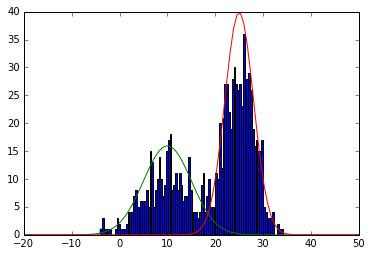

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.hist(values,100)
x = np.linspace(-20, 50, num=100)
y1 = norm.pdf(x, loc=10, scale=5) * 200
y3 = norm.pdf(x, loc=25, scale=3) * 300
plt.plot(x, y1)
plt.plot(x, y3)

Assuming that the class labels are hidden, we only have access to `values`. In each iteration, we complete the data using current parameters, compute the likelihood and gradient of completed data, and update the parameters:

In [14]:
def ll(parameters, data):
    """Compute the likelihood and its gradients.
    
    arguments:
    parameters -- current value of parameters
    data     -- values for all random variables
    """
    p_n, p_m = parameters
    num_classes = len(p_m)
    likelihood = 0
    grad_n = [[0.0] * len(p_n[0])] * num_classes
    grad_m = [0.0] * num_classes
    for instance in data:
        label, value = instance
        likelihood += f_normal_log(value)(p_n[label])
        fprime_n = fprime_normal_log(value)(p_n[label])
        grad_n[label] = [grad_n[label][i] + fprime_n[i] for i in range(num_classes)]
        
        likelihood += f_multinomial_log(label)(p_m)
        fprime_m = fprime_multinomial_log(label)(p_m)
        grad_m = [grad_m[i]+fprime_m[i] for i in range(num_classes)]
    
    gradients = grad_n, grad_m
    return likelihood, gradients

def get_samples(value, parameters, num_samples):
    p_n, p_m = parameters
    num_classes = len(p_m)
    prior = np.exp(p_m)
    prior = [p/sum(prior) for p in prior]
    
    posterior = [0.0] * num_classes
    for i in range(num_classes):
        mu, sigma = p_n[i]
        posterior[i] = norm.pdf(value, loc=mu, scale=sigma) * prior[i]
    posterior = [p/sum(posterior) for p in posterior]

    samples = np.random.multinomial(num_samples, posterior)
    completed = []
    for i in range(num_classes):
        for j in range(samples[i]):
            completed.append((i, value))
    return completed

# unnecessary complication
def complete_data(values, parameters, num_samples=2):
    completed_data = []
    for value in values:
        completed_data += get_samples(value, parameters, num_samples)
    return completed_data


In [26]:
num_classes = 2
normal_parameters = [
    [15.5, 5],
    [15, 5]
]
multinomial_parameters = [15.7, 15.8]
parameters = [normal_parameters, multinomial_parameters]    
completed_data = complete_data(values, parameters)

Before starting to learn the weights, let us compute the log-likelihood of complete data:

In [12]:
data = zip(values, labels)
normal_parameters = [
    [10, 5],
    [25, 3]
]
multinomial_parameters = [15.5, 16]
p = np.exp(multinomial_parameters)
p = [i/sum(p) for i in p]

log_likelihood = 0
for value, label in data:
    log_likelihood += np.log(p[label])
    mu, sigma = normal_parameters[label]
    log_likelihood += norm.logpdf(value, loc=mu, scale=sigma)

print log_likelihood

-3389.62720501


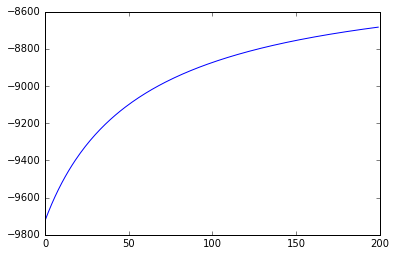

In [28]:
current_params = parameters
current_data = complete_data(values, current_params, num_samples=10)
ll_series = []
for iterations in range(200):
    likelihood, gradients = ll(current_params, completed_data)
    ll_series.append(likelihood)
    g_n, g_m = gradients
    nu = 0.1 / len(completed_data)
    p_n, p_m = parameters
    for i in range(2):
        for j in range(2):
            p_n[i][j] += nu * g_n[i][j]
    for i in range(2):
        p_m[i] += nu * g_m[i]
    current_params = (p_n, p_m)
    current_data = complete_data(values, current_params, num_samples=10)
    
plt.plot(ll_series)

In [33]:
print current_params

([[16.55104836045259, 6.829974864553629], [15.709475390466789, 6.905680062219306]], [15.798033405566205, 15.701966594433795])
